<a href="https://colab.research.google.com/github/skiesindisguise/ProjectCI-Kelompok16-PenerapanAlgoritmaABCUntukOptimalisasiPembentukanStudyGroup/blob/main/ImplementasiAlgoritmaABC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

In [2]:
# Penentuan Constraint
DATA_FILEPATH = 'Dataset_Mahasiswa_Kehadiran_Aktivitas_IPK.xlsx'
NUM_STUDENTS = 500
NUM_GROUPS = 100    # (500 siswa / 100 kelompok = 5 siswa per kelompok)
NUM_CRITERIA = 5    # (Kehadiran, Diskusi, Tugas, E-Learning, IPK)
NUM_CATEGORIES = 3  # Setiap kriteria dibagi menjadi 3 kategori (Pengkategorian digunakan sebagai dasar perhitungan distribusi ideal tiap kelompok.)
GROUP_SIZE = 5      # Setiap kelompok berisi 5 mahasiswa

# Parameter Algoritma ABC
POPULATION_SIZE = 50  # Jumlah "sumber makanan" (solusi)
MAX_ITERATIONS = 300
LIMIT = 20  # Batas trial (limit) sebelum masuk ke fase Scout Bee

# Konfigurasi Fitness (Bobot Kriteria)
# bobot (prioritas) untuk 5 kriteria. Total = 1.0, IPK dan Tugas lebih penting
# CRITERIA_WEIGHTS = np.array([
#     0.1,  # Bobot Kehadiran
#     0.2,  # Bobot Partisipasi Diskusi
#     0.2,  # Bobot Nilai Tugas
#     0.1,  # Bobot Nilai E-Learning
#     0.4   # Bobot IPK
# ])

# # total bobot adalah 1
# assert np.isclose(np.sum(CRITERIA_WEIGHTS), 1.0), "Total bobot kriteria (CRITERIA_WEIGHTS) 1.0"

In [3]:
# INISIALISASI DATA
# Bagian: Pengumpulan Data, Data Preprocessing, dan prasyarat untuk perumusan Fitness

def load_student_data(filepath):
    print(f"Memuat data dari {filepath}...")
    try:
        df = pd.read_excel(filepath)
    except FileNotFoundError:
        print(f"Error: File data '{filepath}' tidak ditemukan.")
        return None, None

    # Mengambil 500 data pertama
    df = df.head(NUM_STUDENTS)

    # Menangani format IPK "3,77" (koma) dari Kaggle
    if 'IPK' in df.columns and df['IPK'].dtype == 'object':
        df['IPK'] = df['IPK'].str.replace(',', '.').astype(float)

    # Mengambil nama siswa untuk referensi output nanti
    student_names = df['Nama'].tolist()

    # Mengambil data numerik dari 5 kriteria dan mengubah ke array numpy untuk perhitungan
    try:
        student_data_raw = df[[
            'Kehadiran (%)',
            'Partisipasi Diskusi (skor)',
            'Nilai Tugas (rata-rata)',
            'Aktivitas E-Learning (skor)',
            'IPK'
        ]].values
        return student_data_raw, student_names
    except KeyError as e:
        print(f"Error: Nama kolom di Excel tidak sesuai. Kolom yang hilang: {e}")
        return None, None


def preprocess_data_to_categories(student_data_raw):
    print("Melakukan preprocessing data (Numerik -> Kategori)...")
    # Membuat array baru dengan ukuran sama seperti data asli, tapi berisi int (kategori)
    categorical_data = np.zeros_like(student_data_raw, dtype=int)

    # Melakukan iterasi pada setiap kriteria dan mengambil seluruh nilainya
    for k in range(NUM_CRITERIA):
        criteria_values = student_data_raw[:, k]

        # batas (threshold) untuk kategori
        low_threshold = np.percentile(criteria_values, 33.3)
        high_threshold = np.percentile(criteria_values, 66.6)

        # Mengubah nilai numerik ke kategori
        categorical_data[:, k] = np.where(criteria_values <= low_threshold, 1,  # 1 = Kurang
                                 np.where(criteria_values <= high_threshold, 2, 3)) # 2 = Sedang, 3 = Baik

    return categorical_data


def calculate_target_distribution(categorical_data):
    print("Menghitung target distribusi (t_i^(k))...")
    target_dist = np.zeros((NUM_CRITERIA, NUM_CATEGORIES))  # Membuat matriks kosong berukuran 5 kriteria, 3 kategori

    # Untuk setiap kriteria:
    # - Dihitung berapa mahasiswa yang termasuk kategori 1, 2, 3
    # - Mencari proporsinya (jumlah mahasiswa di suatu kategori/jumlah seluruh mahasiswa)
    for k in range(NUM_CRITERIA):
        for i_category in range(1, NUM_CATEGORIES + 1):
            category_count = np.sum(categorical_data[:, k] == i_category)
            target_dist[k, i_category - 1] = category_count / NUM_STUDENTS

    return target_dist

In [4]:
# PERHITUNGAN FITNESS

def calculate_group_distribution(groups, categorical_data):
    """
    Menghitung proporsi kategori (g_i^(k)) tiap grup untuk semua kriteria.
    Output: array 3D [jumlah_grup, jumlah_kriteria, jumlah_kategori]
    """
    num_groups = len(groups)
    group_dist = np.zeros((num_groups, NUM_CRITERIA, NUM_CATEGORIES))

    for g, members in enumerate(groups):
        for k in range(NUM_CRITERIA):
            for i_category in range(1, NUM_CATEGORIES + 1):
                count = np.sum(categorical_data[members, k] == i_category)  # Menghitung berapa anggota di kelompok tersebut yang masuk kategori tertentu untuk kriteria k
                group_dist[g, k, i_category - 1] = count / len(members)     # Mengubah jumlah menjadi proporsi (dibagi jumlah anggota kelompok).
    return group_dist

In [5]:
def calculate_group_fitness(group_idx, group_dist, target_dist, alphas=None):
    """
    Menghitung fitness untuk satu grup tertentu.
    Rumus: F = 1 - (Σ_k α_k * |g_i^(k) - t^(k)|) / 2
    """
    if alphas is None:
        alphas = np.ones(NUM_CRITERIA) / NUM_CRITERIA  # bobot tiap kriteria sama rata

    # Menghitung deviasi total kelompok terhadap target
    # Deviasi = total selisih jumlah anggota setiap kelompok dari jumlah ideal
    total_dev = 0
    for k in range(NUM_CRITERIA):
        dev = np.sum(np.abs(group_dist[group_idx, k, :] - target_dist[k, :]))   # Hitung selisih absolut antara proporsi kategori kelompok dan proporsi target
        total_dev += alphas[k] * dev    # Mengalikan deviasi dengan bobot

    fitness = 1 - (total_dev / 2)
    return max(0.0, min(1.0, fitness))  # pastikan di range [0,1]


In [6]:
def calculate_solution_fitness(groups, categorical_data, target_dist, alphas=None):
    """
    Menghitung fitness keseluruhan solusi (semua grup).
    Output: (list_fitness_per_grup, mean_fitness)
    """
    group_dist = calculate_group_distribution(groups, categorical_data)
    fitness_values = [
        calculate_group_fitness(g, group_dist, target_dist, alphas)
        for g in range(len(groups))
    ]
    mean_fitness = np.mean(fitness_values)
    return fitness_values, mean_fitness

In [7]:
def get_mean_fitness(groups, categorical_data, target_dist, alphas=None):
    """
    Fungsi helper untuk langsung ambil nilai mean_fitness saja.
    Digunakan di algoritma ABC untuk mempermudah perhitungan.
    """
    _, mean_fit = calculate_solution_fitness(groups, categorical_data, target_dist, alphas)
    return mean_fit

In [ ]:
class ArtificialBeeColony:
    """
    Implementasi algoritma Artificial Bee Colony (ABC) untuk optimasi pembentukan kelompok belajar.
    Dengan 3 fase:
    1. Employed Bees : mengeksplorasi solusi yang sudah dimiliki
    2. Onlooker Bees : memilih solusi TERBAIK dan mengembangkannya
    3. Scout Bees    : membuat solusi baru jika terjadi stagnasi
    """
    def __init__(self, categorical_data, target_dist, num_groups, max_iterations, num_bees=50):
        """
        Inisialisasi parameter algoritma ABC.
        - categorical_data: data mahasiswa dalam bentuk kategori (1, 2, 3)
        - target_dist: distribusi ideal tiap kategori untuk semua kriteria
        - num_groups: jumlah kelompok yang ingin dibentuk
        - num_bees: jumlah lebah (populasi solusi)
        - max_iterations: jumlah iterasi maksimum
        """
        self.categorical_data = categorical_data
        self.target_dist = target_dist
        self.num_groups = num_groups
        self.num_bees = num_bees
        self.max_iterations = max_iterations

        # Inisialisasi populasi awal (kumpulan solusi acak)
        self.current_population = [self.generate_possible_solution() for _ in range(num_bees)]
        self.current_best_solution = self.current_population[0]
        
        self.population_size = len(self.current_population)
        self.num_employed_bees = self.population_size // 2
        self.num_onlooker_bees = self.population_size - self.num_employed_bees

        self.trials = [0] * self.population_size    # Trial counter untuk mekanisme LIMIT algoritma ABC
        self.test_data = []     # Menyimpan perkembangan fitness tiap iterasi
        self.test_cases = 0     # Menghitung jumlah modifikasi solusi

    def generate_possible_solution(self):
        """
        Membentuk solusi awal dengan cara merandom indeks mahasiswa
        lalu membaginya menjadi sejumlah kelompok (num_groups).
        """
        mahasiswa = list(range(NUM_STUDENTS))
        random.shuffle(mahasiswa)
        groups = np.array_split(mahasiswa, self.num_groups)
        return [list(g) for g in groups]

    def evaluate_fitness(self, groups):
        """
        Menghitung fitness suatu solusi (rata-rata fitness dari seluruh kelompok).
        """
        return get_mean_fitness(groups, self.categorical_data, self.target_dist)

    def apply_random_neighborhood_structure(self, groups):
        """
        Setiap lebah pekerja (employed bee) bertugas mengeksplorasi solusi yang sudah dimiliki. 
        Pada ABC standar (continuous), update solusi dilakukan dengan rumus:
        X_new = X + φ (X – X_partner)
        Namun karena masalah pembentukan kelompok adalah masalah DISCRETE (kombinatorial), maka update 
        dilakukan dengan strategi NEIGHBORHOOD yaitu menukar dua mahasiswa dari dua kelompok berbeda (swap).
        """
        new_groups = [list(g) for g in groups]
        # Memilih dua kelompok acak dan dua mahasiswa acak dari masing-masing kelompok.
        g1, g2 = random.sample(range(len(new_groups)), 2)
        if new_groups[g1] and new_groups[g2]:
            i1 = random.choice(range(len(new_groups[g1])))
            i2 = random.choice(range(len(new_groups[g2])))
            # Tukar posisi dua mahasiswa -> Tujuan: Mencoba pembagian baru yang mirip tapi sedikit berbeda dari solusi lama.
            new_groups[g1][i1], new_groups[g2][i2] = new_groups[g2][i2], new_groups[g1][i1]
        return new_groups

    def sort_population_by_fitness(self, population):
        """
        Mengurutkan populasi berdasarkan nilai fitness (tertinggi ke terendah).
        """
        return sorted(population, key=lambda x: self.evaluate_fitness(x), reverse=True)

    # def choose_solution_with_probability(self, population, probability_list):
    #     """
    #     Memilih solusi berdasarkan probabilitas (fase onlooker bee).
    #     Semakin baik fitness suatu solusi, semakin besar peluang dipilih.
    #     """
    #     r = random.random()         # Menghasilkan angka acak r antara 0 dan 1
    #     cumulative = 0.0            # Menyimpan akumulasi probabilitas
    #     for i in range(len(population)):
    #         cumulative += probability_list[i]   # Tambahkan probabilitas solusi ke akumulasi

    #         # Jika nilai acak r jatuh pada rentang kumulatif saat ini,
    #         # maka solusi tersebut dipilih.
    #         if r <= cumulative:
    #             return population[i]

    def run(self, LIMIT):
        """
        Fungsi utama untuk menjalankan proses optimasi menggunakan ABC.
        """
        gen_fitness = np.zeros(self.max_iterations)

        for iteration in range(self.max_iterations):
            # ==============================
            #      EMPLOYED BEE PHASE
            # ==============================
            # Setiap lebah pekerja mengeksplorasi solusi baru dari solusi yang ada
            for i in range(self.num_employed_bees):
                current_solution = self.current_population[i]
                new_solution = self.apply_random_neighborhood_structure(current_solution)   # swap mahasiswa antar 2 kelompok
                
                # Hitung fitness solusi lama dan solusi baru
                old_fitness = self.evaluate_fitness(current_solution)
                new_fitness = self.evaluate_fitness(new_solution)

                # Jika solusi baru lebih baik, maka solusi lama diganti
                if new_fitness > old_fitness:
                    self.current_population[i] = new_solution
                    self.test_cases += 1
                else:
                    self.trials[i] += 1     # Tambah trial jika tidak membaik

            # ==============================
            #       ONLOOKER BEE PHASE
            # ==============================
            # Menghitung probabilitas tiap fitness
            fitness_list = [self.evaluate_fitness(s) for s in self.current_population]
            total_fitness = sum(fitness_list)
            prob_list = [f / total_fitness for f in fitness_list]

            onlooker_count = 0
            i = 0

            # Loop sampai jumlah lebah onlooker memenuhi batas
            while onlooker_count < self.num_onlooker_bees:
                r = random.random()     # angka acak antara 0–1

                # Jika angka acak lebih kecil dari probabilitas solusi i, solusi tersebut dipilih
                if r < prob_list[i]:  
                    selected = self.current_population[i]   # solusi yang dipilih
                    new_solution = self.apply_random_neighborhood_structure(selected)   # swap mahasiswa antar 2 kelompok

                    old_fit = fitness_list[i]
                    new_fit = self.evaluate_fitness(new_solution)   # Gitung fitness baru

                    # Jika solusi baru lebih baik, update populasi
                    if new_fit > old_fit:
                        self.current_population[i] = new_solution
                        fitness_list[i] = new_fit
                        self.test_cases += 1
                    else:
                        self.trials[i] += 1     # Jika solusi tidak membaik, tambahkan trial

                    onlooker_count += 1  # hanya bertambah jika memilih solusi

                i = (i + 1) % self.population_size  # loop melingkar

            # ==============================
            #        SCOUT BEE PHASE
            # ==============================
            # Jika solusi stagnan (tidak ada peningkatan), maka generate solusi baru
            for i in range(self.population_size):
                # Mekanisme LIMIT algoritma ABC
                if self.trials[i] >= LIMIT:
                    # Ganti dengan solusi baru ketika trial melebihi LIMIT
                    self.current_population[i] = self.generate_possible_solution()
                    self.trials[i] = 0      # reset trial

            # ==============================
            #      UPDATE BEST SOLUTION
            # ==============================
            self.current_population = self.sort_population_by_fitness(self.current_population)
            current_best_fitness = self.evaluate_fitness(self.current_best_solution)

            if self.evaluate_fitness(self.current_population[0]) > current_best_fitness:
                self.current_best_solution = self.current_population[0]

            gen_fitness[iteration] = self.evaluate_fitness(self.current_best_solution)

            # Simpan untuk visualisasi
            self.test_data.append([
                iteration,
                gen_fitness[iteration],
                self.test_cases
            ])

        # Kembalikan solusi terbaik dan nilai fitness-nya
        return self.current_best_solution, gen_fitness[-1]

In [9]:
if __name__ == "__main__":
    """
    Blok utama eksekusi program.
    Menjalankan seluruh tahapan mulai dari:
    - pemuatan dan preprocessing data mahasiswa,
    - pembentukan target distribusi,
    - inisialisasi dan eksekusi algoritma ABC,
    - menampilkan hasil optimasi,
    - serta menyimpan hasil analisis tambahan.
    """
    # Memuat dan mempersiapkan data mahasiswa
    student_data_raw, student_names = load_student_data(DATA_FILEPATH)
    categorical_data = preprocess_data_to_categories(student_data_raw)
    target_dist = calculate_target_distribution(categorical_data)

    # Inisialisasi objek algoritma Artificial Bee Colony (ABC)
    abc = ArtificialBeeColony(
        categorical_data,
        target_dist,
        num_groups=NUM_GROUPS,
        num_bees=POPULATION_SIZE,
        max_iterations=MAX_ITERATIONS
    )

    # Menjalankan proses optimasi
    start_time = datetime.datetime.now()
    best_solution, best_fitness = abc.run(LIMIT=LIMIT)
    end_time = datetime.datetime.now()

    # Output hasil
    print("\n=== HASIL OPTIMALISASI STUDY GROUP (ABC) ===")
    for i, group in enumerate(best_solution[:5]):
        print(f"\nKelompok {i+1}:")
        print([student_names[idx] for idx in group])

    print(f"\nFitness terbaik: {best_fitness:.4f}")
    print(f"Waktu eksekusi: {(end_time - start_time).total_seconds():.2f} detik")

    # Menyimpan data hasil iterasi untuk analisis konvergensi fitness
    print("\nMenyimpan data hasil iterasi ke 'hasil_iterasi_ABC.csv'...")
    abc_test_data = pd.DataFrame(abc.test_data, columns=["Iteration", "Fitness", "Test Cases"])
    abc_test_data.to_csv("hasil_iterasi_ABC.csv", index=False)
    print("File hasil_iterasi_ABC.csv berhasil disimpan.")

    # Simpan hasil pembentukan kelompok ke file CSV
    print("Menyimpan hasil pembentukan kelompok ke 'hasil_kelompok_ABC.csv'...")
    group_results = []
    for i, group in enumerate(best_solution):
        for member_idx in group:
            group_results.append({
                "Kelompok": i + 1,
                "Nama Mahasiswa": student_names[member_idx]
            })
    group_df = pd.DataFrame(group_results)
    group_df.to_csv("hasil_kelompok_ABC.csv", index=False, encoding="utf-8-sig")  # DIGANTI (tambah encoding)
    print("File hasil_kelompok_ABC.csv berhasil disimpan.")

Memuat data dari Dataset_Mahasiswa_Kehadiran_Aktivitas_IPK.xlsx...
Melakukan preprocessing data (Numerik -> Kategori)...
Menghitung target distribusi (t_i^(k))...

=== HASIL OPTIMALISASI STUDY GROUP (ABC) ===

Kelompok 1:
['Cici Pratama', 'Aldi Santoso', 'Oki Ramadhan', 'Ivan Permana', 'Nina Maulana']

Kelompok 2:
['Tio Syahputra', 'Putri Fauzi', 'Ivan Putri', 'Oki Maulana', 'Joko Wulandari']

Kelompok 3:
['Fajar Saputra', 'Ivan Ramadhan', 'Mira Mahardika', 'Gina Pratama', 'Ivan Fauzi']

Kelompok 4:
['Umi Septiani', 'Dina Mahardika', 'Putri Pratama', 'Dina Septiani', 'Rian Pratama']

Kelompok 5:
['Rian Mahardika', 'Lina Ananda', 'Ivan Syahputra', 'Sari Wijaya', 'Kiki Wulandari']

Fitness terbaik: 0.7705
Waktu eksekusi: 1024.29 detik

Menyimpan data hasil iterasi ke 'hasil_iterasi_ABC.csv'...
File hasil_iterasi_ABC.csv berhasil disimpan.
Menyimpan hasil pembentukan kelompok ke 'hasil_kelompok_ABC.csv'...
File hasil_kelompok_ABC.csv berhasil disimpan.


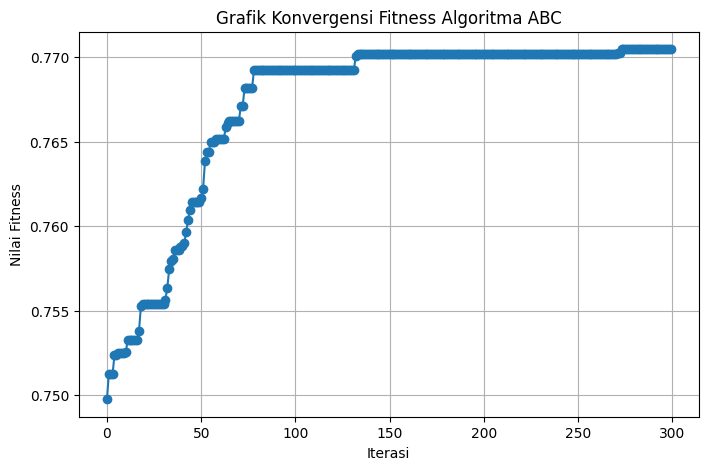

In [10]:
# Visualisasi
try:
    data = pd.read_csv("hasil_iterasi_ABC.csv")
    plt.figure(figsize=(8, 5))
    plt.plot(data["Iteration"], data["Fitness"], marker="o", linestyle="-")
    plt.title("Grafik Konvergensi Fitness Algoritma ABC")
    plt.xlabel("Iterasi")
    plt.ylabel("Nilai Fitness")
    plt.grid(True)
    plt.show()
except FileNotFoundError:
    print("\nFile 'hasil_iterasi_ABC.csv' tidak ditemukan. Jalankan program utama terlebih dahulu.")

In [11]:
print("\n=== EVALUASI OPTIMALITAS ===")

# Distribusi kelompok hasil ABC
group_dist = calculate_group_distribution(best_solution, categorical_data)

total_dev = 0
dev_per_group = []

for g in range(NUM_GROUPS):
    group_dev = 0
    for k in range(NUM_CRITERIA):
        # selisih antara proporsi kategori kelompok dan target
        dev = np.sum(np.abs(group_dist[g, k, :] - target_dist[k, :]))
        group_dev += dev
    dev_per_group.append(group_dev)
    total_dev += group_dev

print(f"Total deviasi seluruh kelompok: {total_dev:.4f}")
print(f"Rata-rata deviasi per kelompok: {np.mean(dev_per_group):.4f}")
print(f"Deviasi minimum: {np.min(dev_per_group):.4f}")
print(f"Deviasi maksimum: {np.max(dev_per_group):.4f}")



=== EVALUASI OPTIMALITAS ===
Total deviasi seluruh kelompok: 229.5320
Rata-rata deviasi per kelompok: 2.2953
Deviasi minimum: 1.2760
Deviasi maksimum: 3.4520
